# Predicting Total Spend on each Category - A Time Series Analysis

### 1. Data Merging and Cleaning

In [1]:
# Import necessary libraries
import os
import glob
import pickle
import warnings
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns
from numpy import mean, std
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# source: https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
transaction_data_urls = [f for f in glob.glob("./datasets/transactions*.csv")]
customer_data_url = './datasets/customers.csv'

In [3]:
# Merge all transaction data in one
dfs = []
for url in transaction_data_urls:
    df_temp = pd.read_csv(url, sep='|')
    dfs.append(df_temp)

In [4]:
trans_df = pd.concat(dfs)
cust_df = pd.read_csv(customer_data_url, sep='|')

In [5]:
trans_df.sample(5)

,cc_num,acct_num,trans_num,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long
192357,3519712847818919,500229982535,ccccf852430e64cbf13328aaa65873fb,1558450584,grocery_net,189.10,0,Williams-Hughes,36.469262,-78.057440
78428,6598363146249120,129989670839,742d00517b36492a09ba399f05257443,1613164489,entertainment,4.22,0,"Flores, Barrett and Carpenter",43.782234,-124.010125
105172,180081300416916,429450179691,e5d052518f55535b1fa98034267554b6,1614004446,entertainment,5.02,0,"Wallace, Rodriguez and Baker",37.822932,-122.184487
158247,4491165020002456,36423595547,9f34668b975c3cd7e2a74b89765484be,1603508414,shopping_pos,47.60,0,Perry and Sons,33.878712,-96.889638
3468,2263776936634396,102635035220,705e17a4cef1313636c2d5db3745f56e,1562441478,gas_transport,9.59,0,Patton Ltd,38.448875,-77.035216


In [6]:
cust_df.sample(5)

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,acct_num
857,393-69-5470,5506276729350979,Lauren,Lewis,F,12914 Melton Shoals Suite 022,Rockville,MD,20850,39.0870,-77.1680,130569,"Engineer, building services",1964-02-15,980509712242
642,392-09-7060,4212545080951,Timothy,Giles,M,152 Carlson Islands Suite 966,Corsicana,TX,75110,32.0868,-96.4762,31790,Immigration officer,1974-02-08,493252252774
802,796-36-1134,4909619797978,Brandy,Nelson,F,413 Price Groves,New Orleans,LA,70131,29.9168,-89.9960,382333,Secretary/administrator,1997-09-16,326474132970
729,561-02-8996,377800244323620,Carla,Holloway,F,069 Arnold Vista Suite 467,Elmont,NY,11003,40.6976,-73.7049,41356,Advertising account planner,1954-10-04,882138752516
887,312-45-5857,347062728167331,Jeremy,Cruz,M,57562 Scott Courts,Mobridge,SD,57601,45.5407,-100.4315,4003,Early years teacher,1977-08-24,467091684054


In [7]:
# Drop all customer-only related columns
cust_columns_to_drop = ['first', 'last', 'ssn', 'gender', 'street', 'city', 'state', 'zip','job','dob']
cust_selected_columns = [col for col in cust_df.columns if col not in cust_columns_to_drop]

In [8]:
# Merge customer info and transaction date
df_merged = trans_df.merge(
    cust_df[cust_selected_columns],
    on=['cc_num', 'acct_num']
)

In [9]:
df_merged.head(5)

,cc_num,acct_num,trans_num,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long,lat,long,city_pop
0,4896331812335761701,149852234418,f3ec0819590302134f03ffdc2f44697f,1646060228,gas_transport,65.17,0,"Larson, Ryan and Huang",38.143430,-90.327335,38.9255,-90.5968,552
1,4896331812335761701,149852234418,c1607c993e41f2c3b42d72d1506bef7b,1644848624,gas_transport,47.58,0,Myers-Reed,39.119498,-90.760379,38.9255,-90.5968,552
2,4896331812335761701,149852234418,6f530db25d20fe351249a54491fd3fde,1645632153,gas_transport,64.43,0,Baker-Bullock,39.384368,-90.361517,38.9255,-90.5968,552
3,4896331812335761701,149852234418,6d11805f2acd938fec99376001afafe8,1645311286,gas_transport,82.47,0,Spencer-Hall,39.443567,-89.752400,38.9255,-90.5968,552
4,4896331812335761701,149852234418,605342f297c575cb1ccf2c08cad082ee,1641571926,gas_transport,50.28,0,"King, Rodriguez and Hancock",38.857278,-89.609525,38.9255,-90.5968,552


In [10]:
df_merged.shape

(4260904, 13)

In [11]:
# standardize categorical features
categorical_features_to_standardize = [
 'category',
 'merchant'
]
for feature in categorical_features_to_standardize:
    df_merged[feature] = df_merged[feature].str.strip().str.lower()

In [12]:
# source: https://stackoverflow.com/questions/19231871/convert-unix-time-to-readable-date-in-pandas-dataframe
from datetime import datetime
df_merged['datetime'] = pd.to_datetime(df_merged['unix_time'], unit='s') 
df_merged['date'] = df_merged['datetime'].dt.date

In [13]:
df_merged.sample(5)

,cc_num,acct_num,trans_num,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long,lat,long,city_pop,datetime,date
4187668,4635049602667653,23079585520,e8f77369f759d93c555350a290ae7c97,1643025040,home,2.07,0,thomas inc,39.960382,-75.362574,40.1476,-74.6615,4637,2022-01-24 11:50:40,2022-01-24
1945232,4289226801824223,550157085827,970e4edb1bc7ace48b52524ec14cb3ca,1605323732,shopping_pos,11.59,0,davis-meyer,41.783635,-81.971017,41.5084,-81.6076,769341,2020-11-14 03:15:32,2020-11-14
2808204,347203350516029,58833597709,14aa0ecf20e60276df1a6538362c651a,1593260530,shopping_net,23.79,0,jones llc,35.167623,-97.632855,35.4110,-97.4388,640470,2020-06-27 12:22:10,2020-06-27
2818129,374119925512531,674603562370,2bf07c54856c6d01ba74bd6aee20a86e,1640918474,home,92.94,0,owens group,36.765828,-95.695258,36.3116,-95.1158,5110,2021-12-31 02:41:14,2021-12-31
1789163,180036374545891,999389892260,5b4424c7f99e149f5becc98b0a07a7a2,1597748844,shopping_net,522.32,0,"johnston, ewing and castro",38.264292,-89.976859,38.1204,-90.5546,20714,2020-08-18 11:07:24,2020-08-18


In [14]:
# Drop all non-category related columns
columns_to_remove = ['cc_num', 'trans_num', 'unix_time', 'is_fraud', 'merchant',
                     'lat','long', 'merch_lat', 'merch_long', 'datetime', 'city_pop']
selected_columns = [col for col in df_merged.columns if col not in columns_to_remove]

In [15]:
df_cleaned = df_merged[selected_columns].reset_index(drop=True)

In [16]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4260904 entries, 0 to 4260903
Data columns (total 4 columns):
 #   Column    Dtype  
---  ------    -----  
 0   acct_num  object 
 1   category  object 
 2   amt       float64
 3   date      object 
dtypes: float64(1), object(3)
memory usage: 130.0+ MB


In [17]:
df_cleaned.head(5)


,acct_num,category,amt,date
0,149852234418,gas_transport,65.17,2022-02-28
1,149852234418,gas_transport,47.58,2022-02-14
2,149852234418,gas_transport,64.43,2022-02-23
3,149852234418,gas_transport,82.47,2022-02-19
4,149852234418,gas_transport,50.28,2022-01-07


In [18]:
df_cleaned.shape

(4260904, 4)

In [19]:
min(df_cleaned["date"]), max(df_cleaned["date"])

(datetime.date(2018, 12, 31), datetime.date(2022, 12, 31))

In [20]:
# save the transformed dataframe
df_cleaned.to_csv("df_cleaned.csv")

### 2. Data transformation for time series analysis

In [21]:
# Copy the data into a new DataFrame
df = df_cleaned.copy()

# Group the data by 'date' and 'category', and calculate the aggregations
grouped_df = df.groupby(['date', 'category']).agg({
    'amt': 'sum',
    'acct_num': 'count'
}).reset_index()

In [22]:
# Rename the columns
grouped_df.columns = ['Date', 'Category', 'Total Spend', 'Transaction Count']

# Pivot the dataframe to have separate dataframes for each category
category_dfs = {}
categories = grouped_df['Category'].unique()

for category in categories:
    category_df = grouped_df[grouped_df['Category'] == category].copy()
    category_df.drop('Category', axis=1, inplace=True)
    category_dfs[category] = category_df

In [23]:
# Example: Accessing the time series dataframe for 'kids_pets' category
kids_pets_df = category_dfs['kids_pets']
kids_pets_df.head(5)


,Date,Total Spend,Transaction Count
27,2019-01-16,1010.77,1
107,2019-03-03,41.83,2
114,2019-03-05,23.15,1
205,2019-04-02,19.66,1
252,2019-04-13,23.28,1


In [24]:
category_dfs.keys()

dict_keys(['gas_transport', 'grocery_pos', 'misc_net', 'shopping_net', 'shopping_pos', 'grocery_net', 'health_fitness', 'kids_pets', 'misc_pos', 'entertainment', 'food_dining', 'personal_care', 'home', 'travel'])

In [25]:
# save the category_dfs into a dictionary for further use
with open('data_dict.pkl', 'wb') as fp:
    pickle.dump(category_dfs, fp)

### 3. EDA

In [ ]:
# Run from here without performing data cleaning, do not forget to import libraries from the start cell
category_dfs = pd.read_pickle(r'data_dict.pkl')

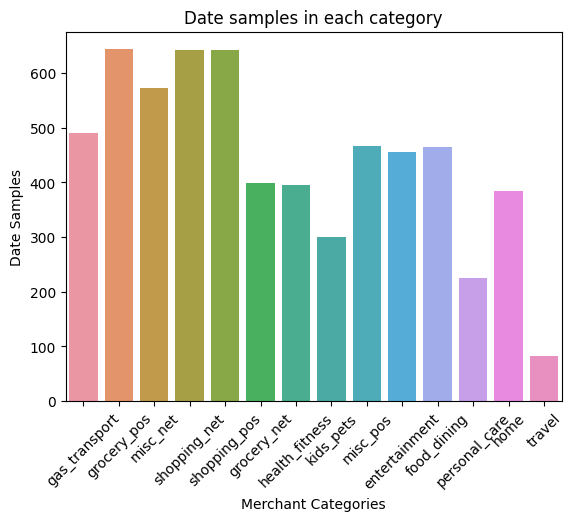

In [26]:
# See the data samples in each category
cat_samples = [len(value) for value in category_dfs.values()]

# Create a bar plot using Seaborn
sns.barplot(x=categories, y=cat_samples)

plt.xlabel('Merchant Categories')
plt.ylabel('Date Samples')
plt.title('Date samples in each category')
plt.xticks(rotation=45)
plt.show()

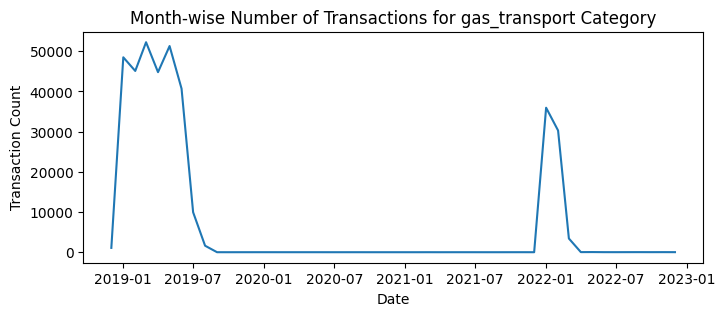

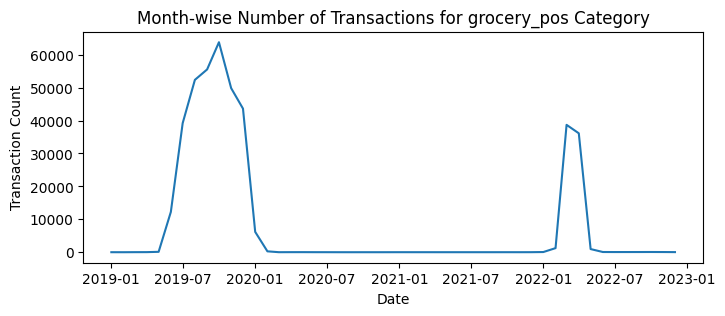

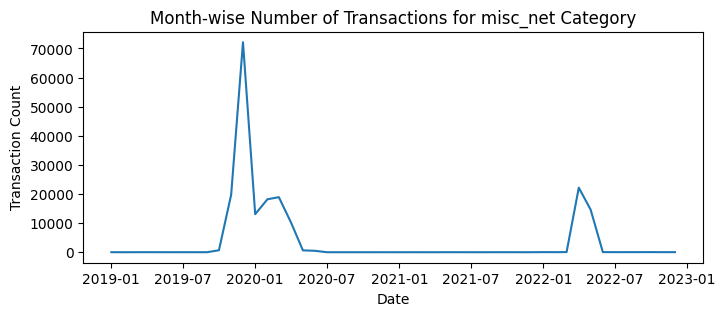

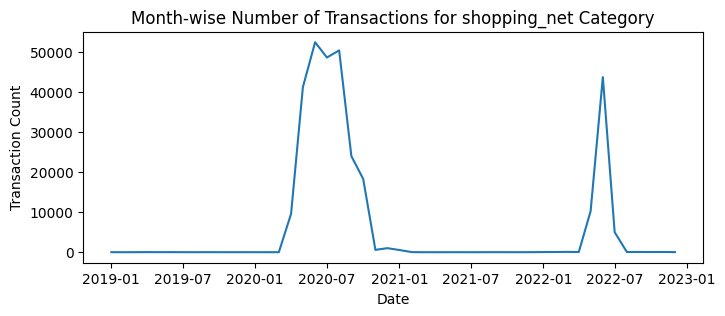

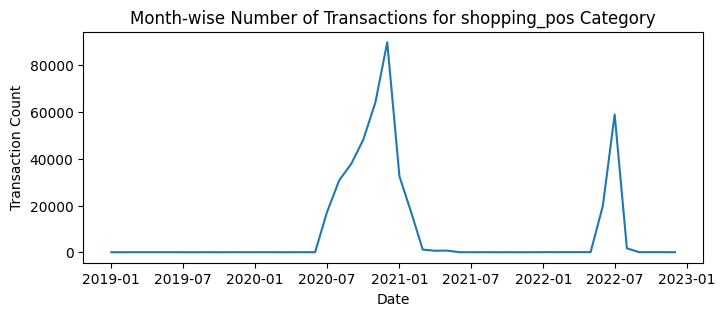

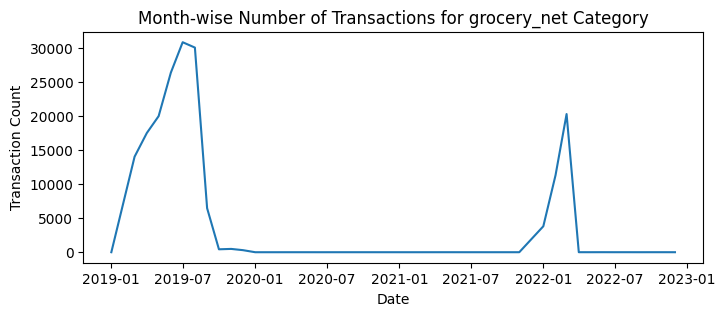

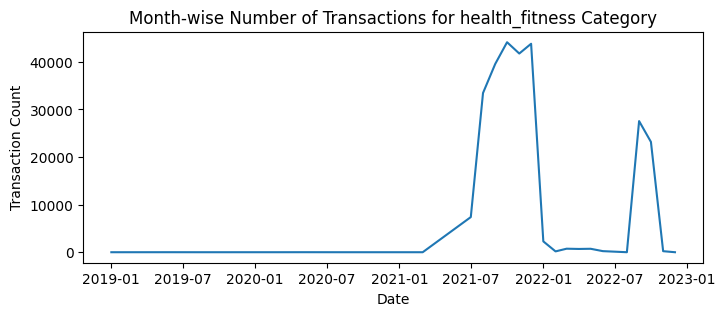

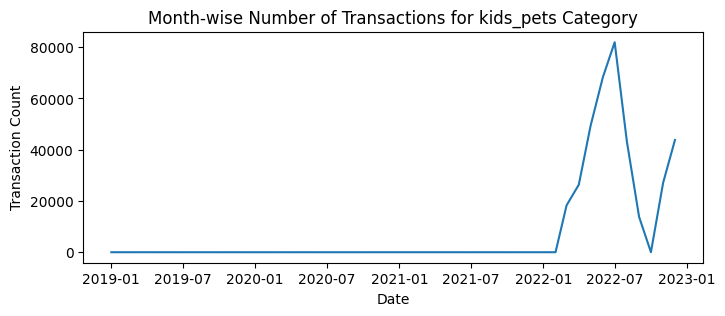

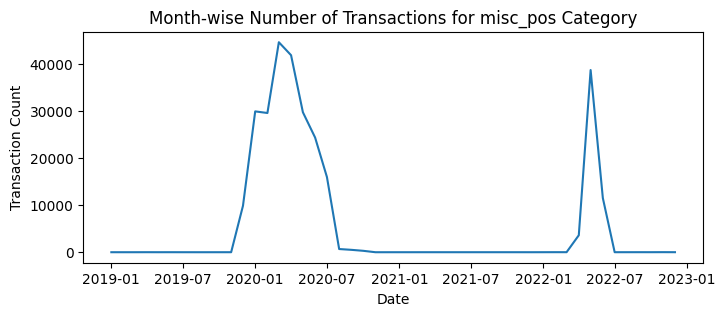

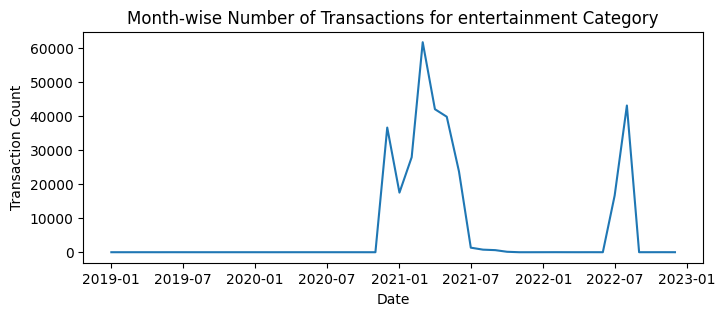

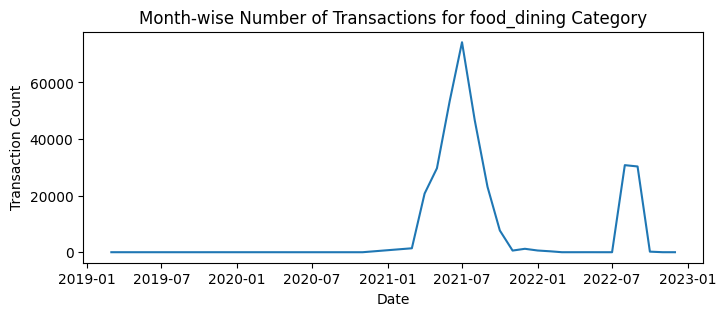

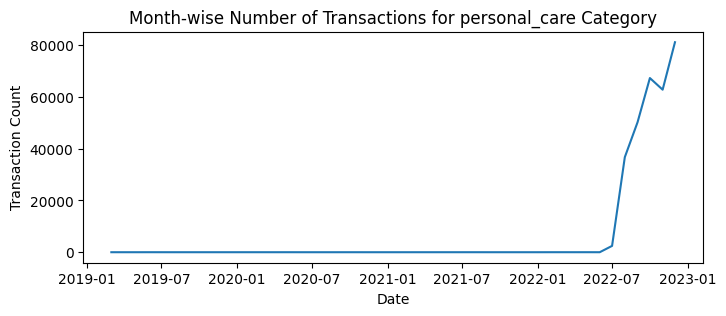

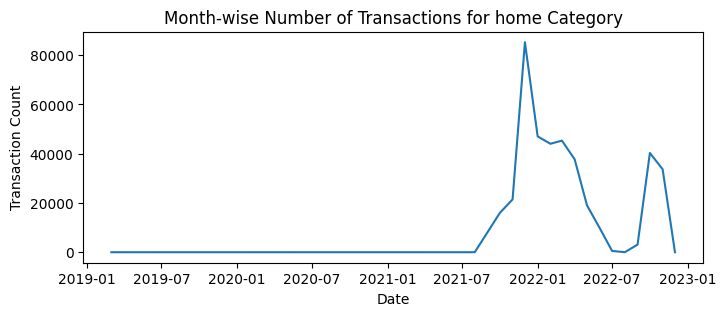

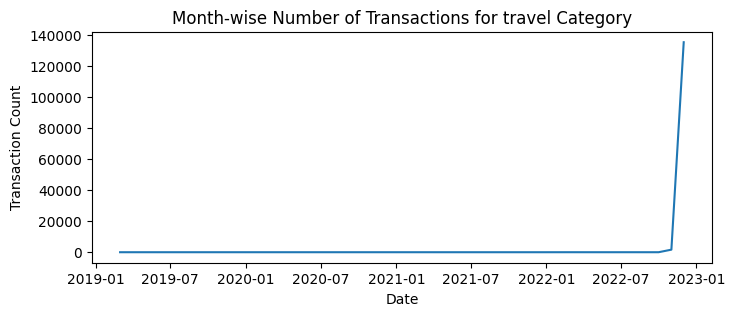

In [27]:
# month-wise number of transactions for each category

# Iterate through the category_dfs dictionary and plot the month-wise number of transactions
for category, df in category_dfs.items():
    df['Date'] = pd.to_datetime(df['Date'])
    monthly_counts = df.groupby(df['Date'].dt.to_period('M'))['Transaction Count'].sum()
    monthly_counts.index = monthly_counts.index.to_timestamp()
    
    # Plot the month-wise number of transactions
    plt.figure(figsize=(8, 3))
    plt.plot(monthly_counts.index, monthly_counts)
    plt.xlabel('Date')
    plt.ylabel('Transaction Count')
    plt.title(f'Month-wise Number of Transactions for {category} Category')
    plt.show()


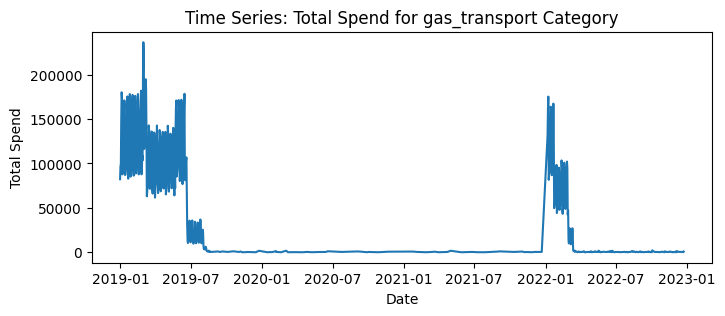

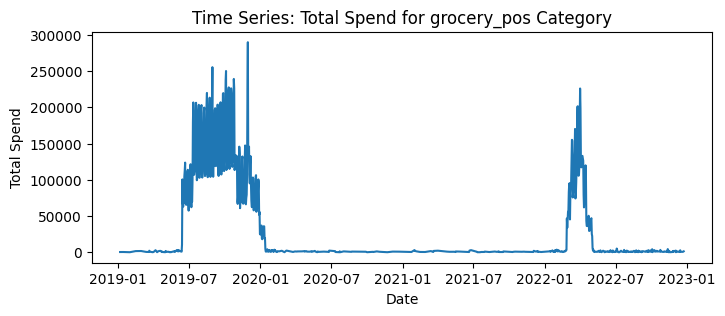

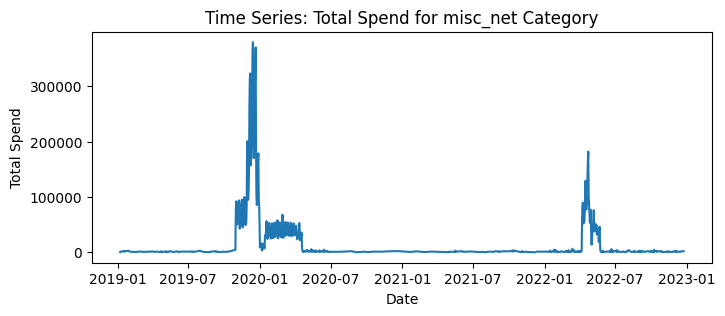

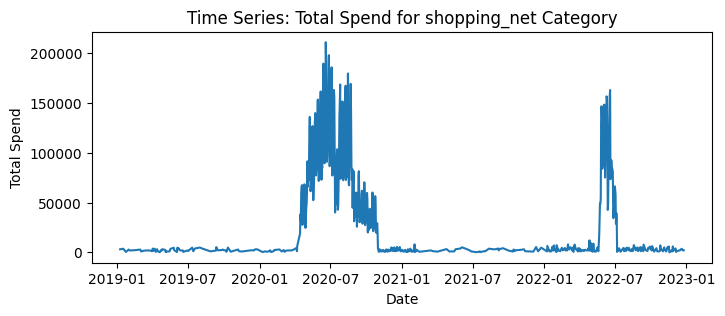

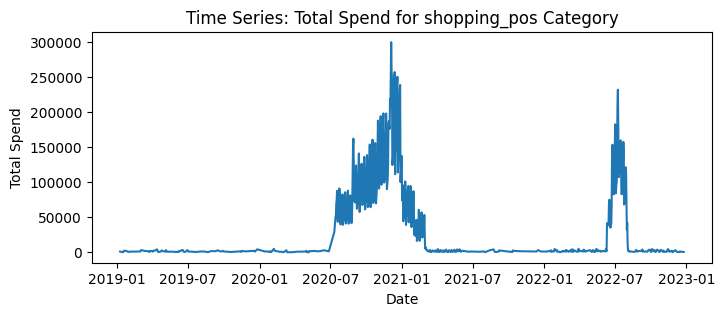

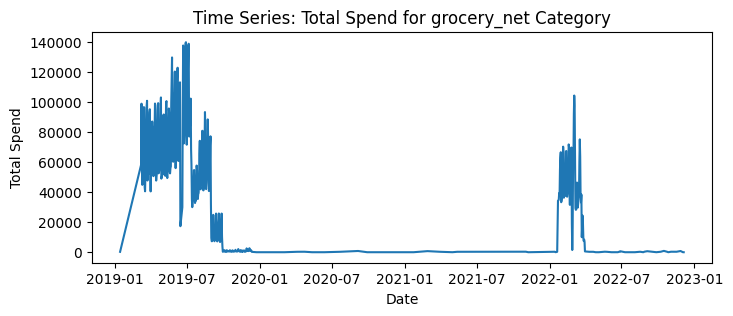

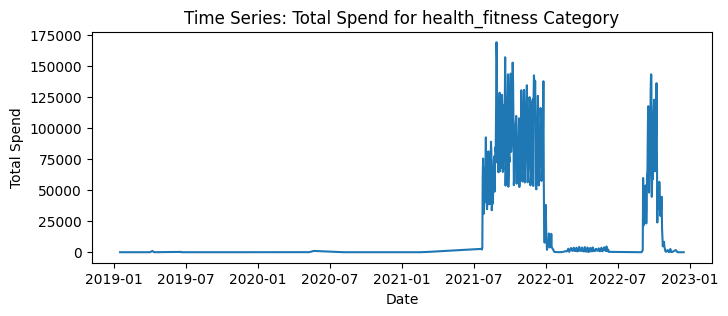

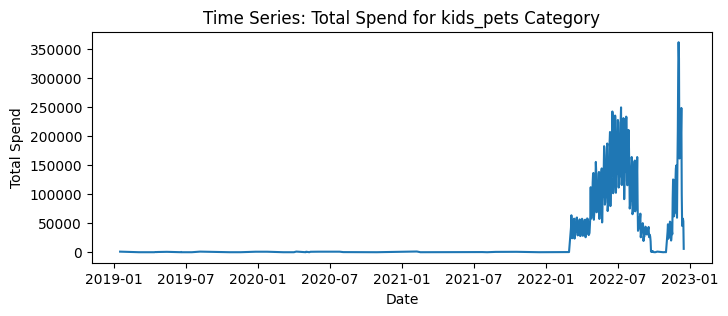

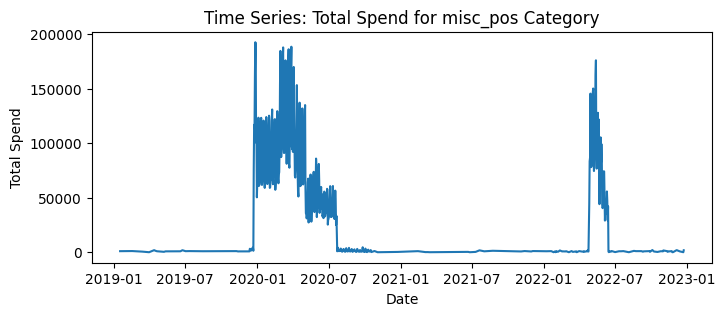

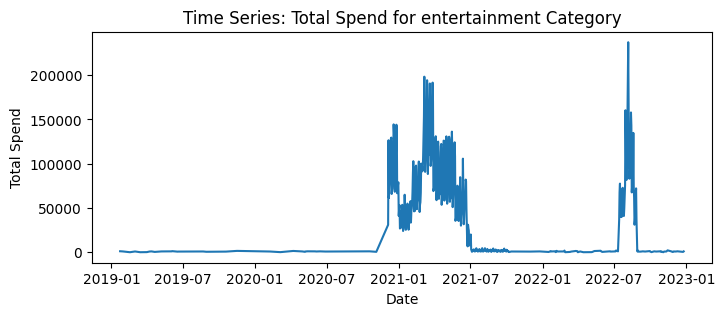

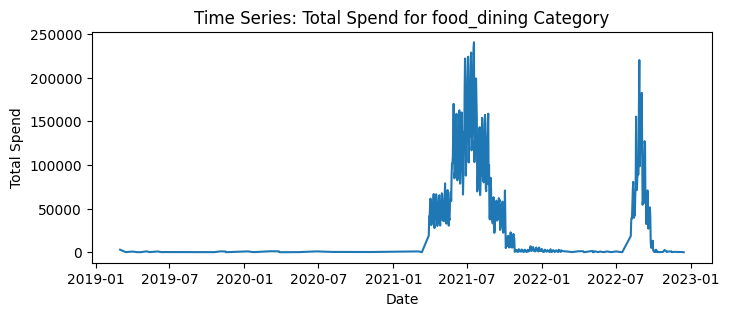

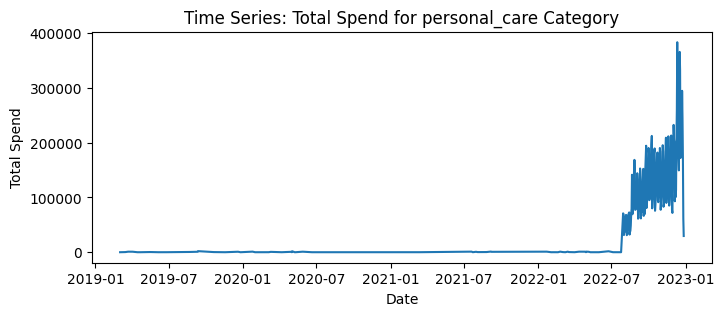

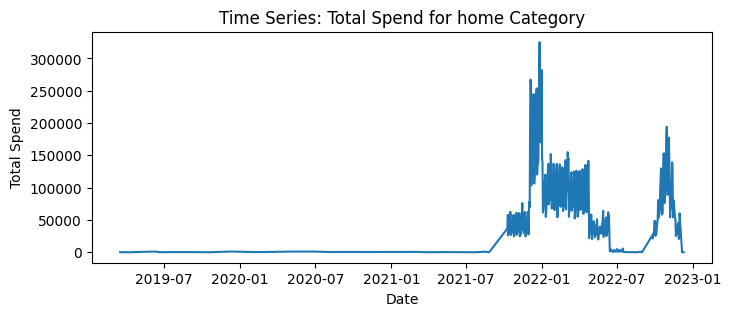

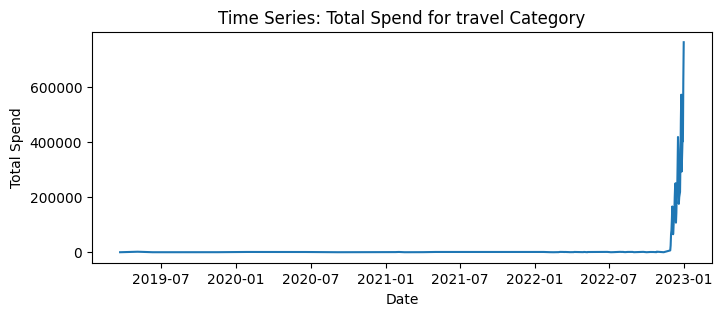

In [28]:
# Visualise the trend of expenditure for each category from year 2019 to 2023
for category in category_dfs.keys():
    category_data = category_dfs[category]
    plt.figure(figsize=(8, 3))
    sns.lineplot(data=category_data, x='Date', y='Total Spend')
    plt.xlabel('Date')
    plt.ylabel('Total Spend')
    plt.title(f'Time Series: Total Spend for {category} Category')
    plt.show()

### Comment on the data: 
The given bank transactions data is not up to the mark and does not exihibit clear patterns or trends over the time of four years. There are very, very less  or close to zero number of transactions for a certain period of time which is unusual. The rise in the total spend is 10x to 30x times compared to lower spends.

### Check if the data is stationary

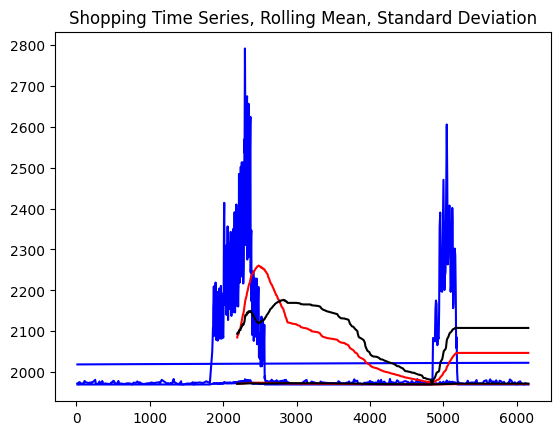

In [32]:
df_shop = category_dfs["shopping_pos"]
# Create a rolling mean and standard deviation for the data
rolling_mean = df_shop .rolling(200).mean()
rolling_std = df_shop .rolling(200).std()

# plot rolling mean, std deviation
plt.plot(df_shop , color="blue",label="Original Data")
plt.plot(rolling_mean, color="red", label="Rolling Mean")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation")
plt.title("Shopping Time Series, Rolling Mean, Standard Deviation")
plt.show()

There will be no trends or seasonal patterns in a stationary time series. Stationarity should be checked because it not only simplifies time series modelling, but it is an underlying assumption in many time series approaches.

In [33]:
# Importing adfuller from statsmodel library
from statsmodels.tsa.stattools import adfuller
adft = adfuller(df_shop["Total Spend"],autolag="AIC")
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

       Values                       Metric
0   -2.205792              Test Statistics
1    0.204150                      p-value
2   15.000000             No. of lags used
3  626.000000  Number of observations used
4   -3.440839          critical value (1%)
5   -2.866168          critical value (5%)
6   -2.569235         critical value (10%)


Our data is not stationary because our p-value is larger than 5% and the test statistic is greater than the critical value. </br>
Source: https://builtin.com/data-science/time-series-python

### See for Autocorrelation

In [34]:
autocorrelation_lag1 = df_shop["Total Spend"].autocorr(lag=100)
print("200 days Lag: ", autocorrelation_lag1)

autocorrelation_lag3 = df_shop["Total Spend"].autocorr(lag=200)
print("400 days Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = df_shop["Total Spend"].autocorr(lag=300)
print("600 days Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = df_shop["Total Spend"].autocorr(lag=400)
print("800 days Lag: ", autocorrelation_lag9)

200 days Lag:  -0.0021791666352117367
400 days Lag:  -0.4947889121269564
600 days Lag:  0.5186815908758716
800 days Lag:  0.23088645437913424


Autocorrelation is a measure of how correlated time series data is with past values at a specific point in time, which has wide-ranging implications in many industries. For example, if our expenditure data for shopping category has a significant autocorrelation, we can conclude that high spend amount today indicate a likelihood that they will be high tomorrow as well.

### 4. Build a time series Baseline Model on Shopping Category (because it has more trend than others)
Choosing just one category for now to compare the results.

In [2]:
# Run from here without performing data cleaning & EDA, do not forget to import libraries
category_dfs = pd.read_pickle(r'data_dict.pkl')

In [3]:
# get shopping data from category dfs dictionary
data = category_dfs["shopping_pos"]
data.shape 

(642, 3)

In [5]:
min(data["Date"]), max(data["Date"])

(datetime.date(2019, 1, 8), datetime.date(2022, 12, 25))

In [6]:
# Convert the 'Date' column to a pandas datetime object and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

### Experiment 1: Exponential Weighted Moving Average

Note: Predicting the spend datewise - Because if we resample the data to month, we won't have enough data samples to train. (4 years data-> 48 samples). The predictions for each date could be then summed up to get prediction for a month or a season.

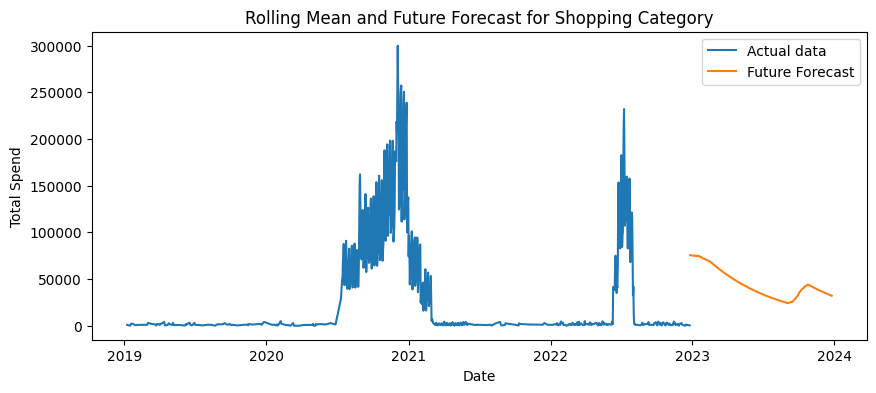

In [7]:
# Calculate the rolling mean with a window size of 1 year (for 365 days)
pred_ewm = data['Total Spend'].ewm(span=365, adjust=False).mean()

# Use the rolling mean to predict future values for the next year
last_date = data.index[-1]
next_year = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=365, freq='D')

# save the forecast into a pandas series for visualization
future_forecast = pd.Series(pred_ewm[-365:].values, index=next_year[:365])

# Plot the rolling mean and future forecast
plt.figure(figsize=(10, 4))
plt.plot(data["Total Spend"], label='Actual data')
plt.plot(future_forecast, label='Future Forecast')
plt.xlabel('Date')
plt.ylabel('Total Spend')
plt.title('Rolling Mean and Future Forecast for Shopping Category')
plt.legend(loc='best')
plt.show()


In [8]:
# importing means squared error metrics package from sklearn
from sklearn.metrics import mean_squared_error

#Taking 30% of the data for testing
rmse_ewma = np.sqrt(mean_squared_error(data["Total Spend"][450:], pred_ewm[450:]))
print("RMSE for Exponential Weighted Moving Average on test data:", rmse_ewma)

RMSE for Exponential Weighted Moving Average on test data: 50845.22123573961


### 5. Build complex models

### Experiment 2: ARIMA on Shopping Category

In [9]:
# importing ARIMA model from statsmodel
from statsmodels.tsa.arima.model import ARIMA

### Normalize the data using log scale
We can stabilize the variance and make it more constant over time by using a log transformation. Log transformation may help in the normalization of data distribution as well. This can help models that assume constant variance, such as linear regression or ARIMA models in better performance. Because our data is skewed and has a long tail, we believe using the logarithm can compress the range of values and make the distribution more symmetric. 

In [10]:
# Performing log transformation
df = np.log(data.drop(["Transaction Count"], axis=1))

### Train-Test Split

In [11]:
# Split the data into train and test sets (70-30 ratio)
train_size = int(len(df) * 0.7)
train, test = df[:train_size], df[train_size:]

In [12]:
train.sample()

,Total Spend
Date,
2021-03-06,7.942924


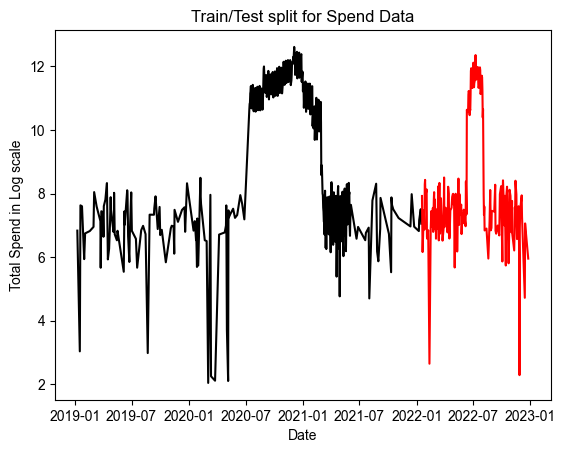

In [13]:
#Plot train and test sets
plt.plot(train["Total Spend"], color = "black")
plt.plot(test["Total Spend"], color = "red")
plt.title("Train/Test split for Spend Data")
plt.ylabel("Total Spend in Log scale")
plt.xlabel('Date')
sns.set()
plt.show()

In [14]:
# Importing auto arima from pmdarima
from pmdarima.arima import auto_arima
model_arima = auto_arima(train["Total Spend"], trace=True, error_action='ignore', suppress_warnings=True)
model_fit_arima = model_arima.fit(train["Total Spend"])
forecast = model_fit_arima.predict(n_periods=len(test))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1116.525, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1238.975, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1184.791, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1121.455, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1236.975, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1113.493, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1112.058, Time=0.03 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1113.271, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1113.711, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1100.748, Time=0.22 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1091.721, Time=0.23 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1095.039, Time=0.25 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1107.581, Time=0.36 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1099.255, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept

/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


#### Note: Auto ARIMA saves time and effort by automatically finding the optimal order parameters (p,q,d)- no need for manual hyperparameter tuning

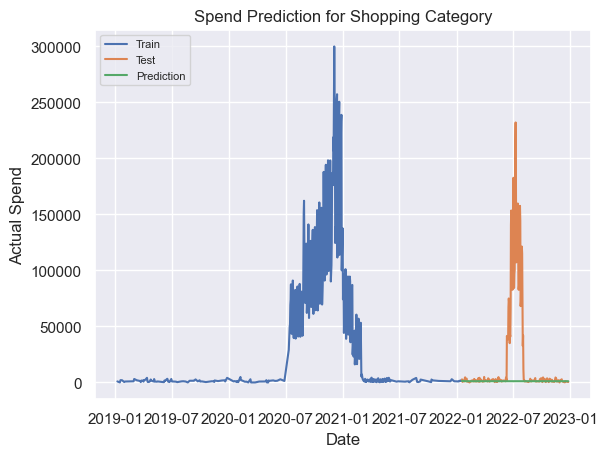

In [15]:
# saving predictions into forecast dataframe for visualisation
fdf = pd.DataFrame({'Predictions': forecast, 'Date':test.index})

plt.plot(train.index, np.exp(train["Total Spend"]), label='Train')
plt.plot(test.index, np.exp(test["Total Spend"]), label='Test')
plt.plot(fdf["Date"], np.exp(fdf["Predictions"]), label='Prediction')
plt.title('Spend Prediction for Shopping Category')
plt.xlabel('Date')
plt.ylabel('Actual Spend')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error
rmse_arima = np.sqrt(mean_squared_error(np.exp(test["Total Spend"]), np.exp(forecast)))
print("RMSE for ARIMA on Shopping category: ", rmse_arima)

RMSE for ARIMA on Shopping category:  58189.14460392569


### 6. Build complex model - adding more features

### Experiment 3: SARIMAX on Shopping Category

We will be using the seasonal ARIMA with extra features as input to the model to see if the model performs better. So performing seasonal decomposition first to use the decomposed values.

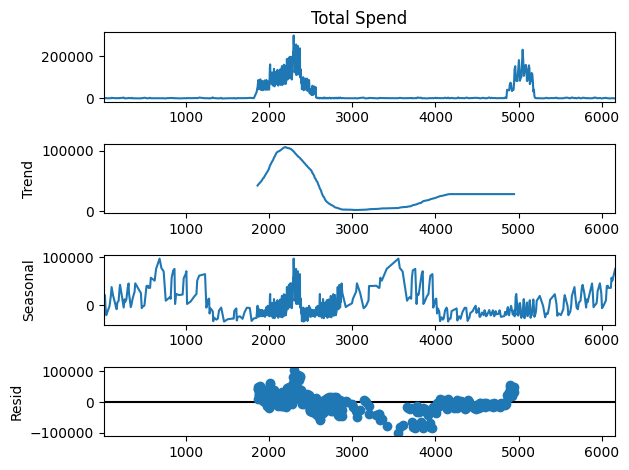

In [4]:
# importing seasonal_decompose package from statsmodel library
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(data["Total Spend"],model='additive', period=200)
decompose.plot()
plt.show()

### Feature Engineering: Include additional features

In [5]:
# This time we do not take the log transformation 
df_new = data.copy()

### Reason to not take log: 
1. Log transformations amplifies the effect of outliers. The log transformation may have increased errors and RMSE as the highest spends in our data could be taken as outliers. 

2. Model Assumptions: SARIMA uses raw data. Log transformations may disrupt the model's assumptions and lower performance.

In [6]:
# Saving the decomposed components into new columns for forecasting
df_new['Trend'] = decompose.trend
df_new['Seasonal'] = decompose.seasonal
df_new['Residual'] = decompose.resid

In [7]:
df_new.sample()

,Date,Total Spend,Transaction Count,Trend,Seasonal,Residual
5007,2022-07-03,143254.27,2001,NaN,2615.201044,NaN


In [8]:
# Split the data into train and test sets
train_size = int(len(df_new) * 0.7)
train_data, test_data = df_new[:train_size], df_new[train_size:]

### See correlation, if very less remove

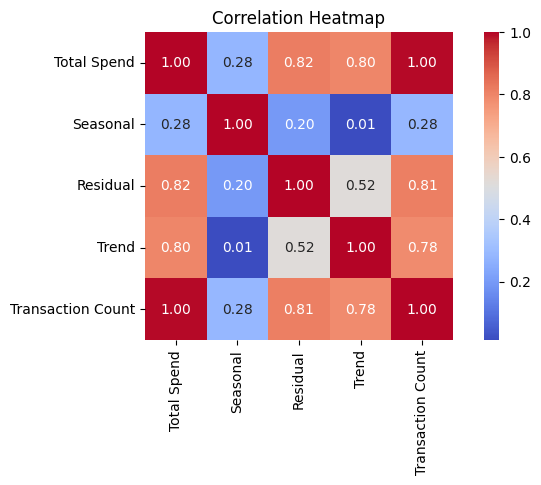

In [9]:
correlation_matrix = train_data[['Total Spend', 'Seasonal', 'Residual', 'Trend', 'Transaction Count']].corr()

# Plot heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Heatmap')
plt.show()

### Not using "Seasonal" feature as it has very low correlation score with the Total Spend

In [12]:
# Find optimal SARIMAX parameters using auto_arima
model_sx = auto_arima(train_data['Total Spend'], trace= True, exogenous=train_data[['Trend', 'Residual', 
                                                                    'Transaction Count']])

# Fit the SARIMAX model on the training datax
model_fit_sx = model_sx.fit(train_data['Total Spend'], exogenous=train_data[['Trend', 'Residual',
                                                                            'Transaction Count']])


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=10067.477, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10270.302, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10268.701, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10266.961, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10268.303, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10166.456, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=10038.425, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=10147.494, Time=0.04 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=10126.543, Time=0.09 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=10159.088, Time=0.09 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=10159.497, Time=0.07 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=10120.334, Time=0.05 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=10030.142, Time=0.27 sec
 ARIMA(5,1,3)(0,0,0)[0] i

In [14]:
# Forecast on the test data using the decomposed components and transaction count
forecast = model_fit_sx.predict(n_periods=len(test_data),
                             exog=test_data[['Trend', 'Residual',
                                            'Transaction Count']])

# Evaluate the forecast using root mean squared error (RMSE)
rmse_sx = mean_squared_error(test_data['Total Spend'], forecast, squared=False)
print('RMSE for SARIMAX on Shopping Category:', rmse_sx)

RMSE for SARIMAX on Shopping Category: 57970.26569129185


/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


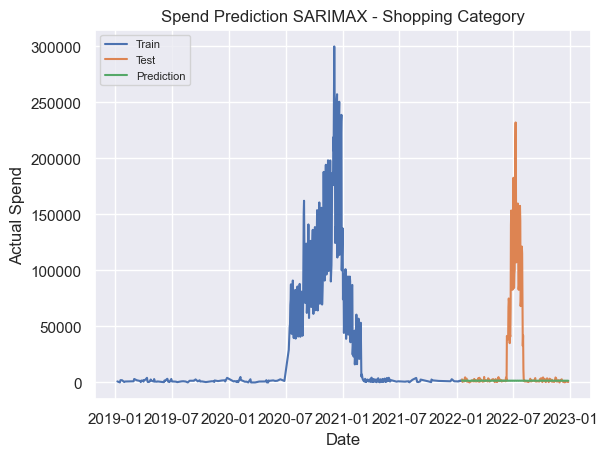

In [54]:
# Saving forecast dataframe for visualization
fdf_sx = pd.DataFrame({'Predictions': forecast, 'Date':test_data.index})

plt.plot(train_data.index, train_data["Total Spend"], label='Train')
plt.plot(test_data.index, test_data["Total Spend"], label='Test')
plt.plot(fdf_sx["Date"], fdf_sx["Predictions"], label='Prediction')
plt.title('Spend Prediction SARIMAX - Shopping Category')
plt.xlabel('Date')
plt.ylabel('Actual Spend')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### 7. Comparing the Results

In [55]:
# Saving the rmse values into list
results = [['Exponential WMA', rmse_ewma], ['ARIMA', rmse_arima], ['SARIMAX', rmse_sx]]
  
# Create the pandas DataFrame for results
df_results = pd.DataFrame(results, columns=['Method', 'RMSE'])
df_results

,Method,RMSE
0,Exponential WMA,50845.221236
1,ARIMA,58189.144604
2,SARIMAX,57970.265691


### 8. Discussion: 
1. The Exponential Weighted moving average model performed relatively well in capturing the patterns and trends in our time series data. The EWMA approach is a simple and effective baseline model that assigns exponentially decreasing weights to past observations, giving more importance to recent data points.

2. The ARIMA approach assumes that the data is stationary and seeks to capture linear relationships and patterns. The higher RMSE compared to EWMA suggests that the ARIMA model may not have captured all the complexities and non-linearities present in the data.

3. Incorporation of Exogenous Variables to the SARIMAX model and using the raw data has shown slight improvement in the results, implying the best results of all. 

### 9. Conclusion: 
1. The baseline EWMA model is a rule-based model and does not work everytime for complex datasets. Moreover, EWMA may miss long-term trends (if we want to forecast for a year or so), seasonality, and other complex data patterns since it emphasises current observations.

2. So, in this task the best model would be SARIMAX. With more data handling and feature engineering, the SARIMAX model can also be improved further.

### 10. Creating a model for each category

In [15]:
# Run from here without performing data cleaning & EDA, do not forget to import libraries
category_dfs = pd.read_pickle(r'data_dict.pkl')

In [16]:
# Importing auto arima from pmdarima
from pmdarima.arima import auto_arima
    
# Create a dictionary to store the ARIMA models for each category
sarimax_models = {}

# Iterate over the category_dfs dictionary
for category, df in category_dfs.items():

    # Convert the 'Date' column to a pandas datetime object and set it as the index
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    # get the trend and resid from seasonal decompose
    decompose = seasonal_decompose(df["Total Spend"],model='additive', period=30)
    
    df['Trend'] = decompose.trend
    df['Residual'] = decompose.resid
    
    model_sx = auto_arima(df['Total Spend'], exogenous=df[['Trend', 'Residual', 
                                                            'Transaction Count']])

    # Fit the SARIMAX model on the training datax
    model_fit_sx = model_sx.fit(df['Total Spend'], exogenous=df[['Trend', 'Residual',
                                                                'Transaction Count']])
    
    # Store the ARIMA model in the dictionary
    sarimax_models[category] = model_fit_sx

In [17]:
sarimax_models

{'gas_transport': ARIMA(order=(5, 1, 5), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 'grocery_pos': ARIMA(order=(2, 1, 3), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 'misc_net': ARIMA(order=(5, 1, 4), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 'shopping_net': ARIMA(order=(5, 1, 4), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 'shopping_pos': ARIMA(order=(5, 1, 4), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 'grocery_net': ARIMA(order=(5, 1, 4), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 'health_fitness': ARIMA(order=(5, 1, 4), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 'kids_pets': ARIMA(order=(0, 1, 2), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 'misc_pos': ARIMA(order=(5, 1, 4), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 'entertain

In [18]:
# save the category_dfs into a dictionary for further use
with open('sarimax_models.pkl', 'wb') as fp:
    pickle.dump(sarimax_models, fp)

## Appendix

### Experiment 4: Removing the close-to-zero values at the start of the time series
Starting the time series from a later point where the values are more meaningful and representative of the patterns we want to capture. This can potentially improve the forecasting accuracy, especially if the earlier zero values do not provide any useful information for predicting future values.

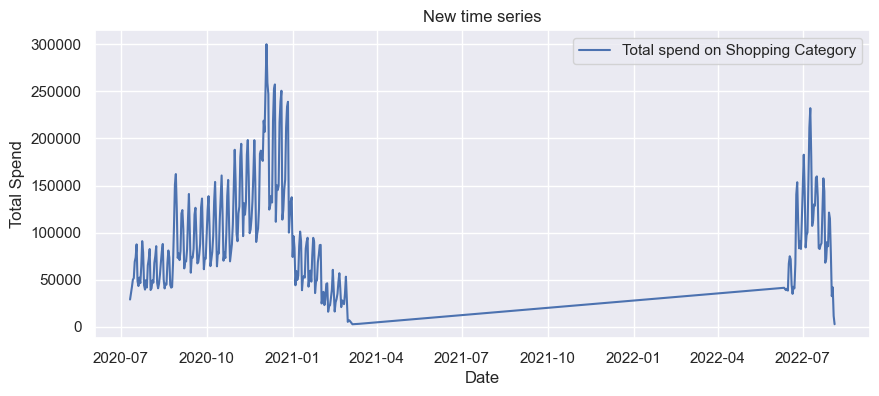

In [28]:
# Remove transaction count less than 50
data_new = data[data['Transaction Count'] > 50]

# Plot the new time series
plt.figure(figsize=(10, 4))
plt.plot(data_new["Total Spend"], label='Total spend on Shopping Category')
plt.xlabel('Date')
plt.ylabel('Total Spend')
plt.title('New time series')
plt.legend(loc='best')
plt.show()


In [38]:
# Split the data into train and test sets
train_size = int(len(data_new) * 0.75)
train, test = data_new[:train_size], data_new[train_size:]

In [39]:
# Importing auto arima from pmdarima
from pmdarima.arima import auto_arima
model_arima_new = auto_arima(train["Total Spend"], trace=True, error_action='ignore', suppress_warnings=True)
model_fit_arima_new = model_arima_new.fit(train["Total Spend"])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5057.328, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5152.648, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5152.950, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5152.208, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5150.651, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5125.479, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5104.241, Time=0.03 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5042.832, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5095.586, Time=0.02 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=5087.564, Time=0.05 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5102.113, Time=0.06 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5101.852, Time=0.04 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=5083.271, Time=0.03 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0]             : 

In [40]:
forecast_new = model_fit_arima_new.predict(n_periods=len(test))
rmse_arima_new = np.sqrt(mean_squared_error(test["Total Spend"], forecast_new))
print("RMSE for new ARIMA on Shopping category: ", rmse_arima_new)

RMSE for new ARIMA on Shopping category:  72187.28719739965


In [41]:
# Predict on future dates - next three months
future_dates = pd.date_range(start='2023-01-01', periods=120, freq='D')
forecast_f = model_fit_arima_new.predict(n_periods=120)

In [42]:
# Create a DataFrame of the forecasted values
forecast_df = pd.DataFrame({'Date': future_dates, 'Forecast': forecast_f})
forecast_df.set_index('Date', inplace=True)

# Print the forecasted values
forecast_df.sample(5)

,Forecast
Date,
2023-04-30,33763.317702
2023-02-28,13001.469049
2023-01-25,21078.494234
2023-03-11,42051.845143
2023-03-02,33235.986251


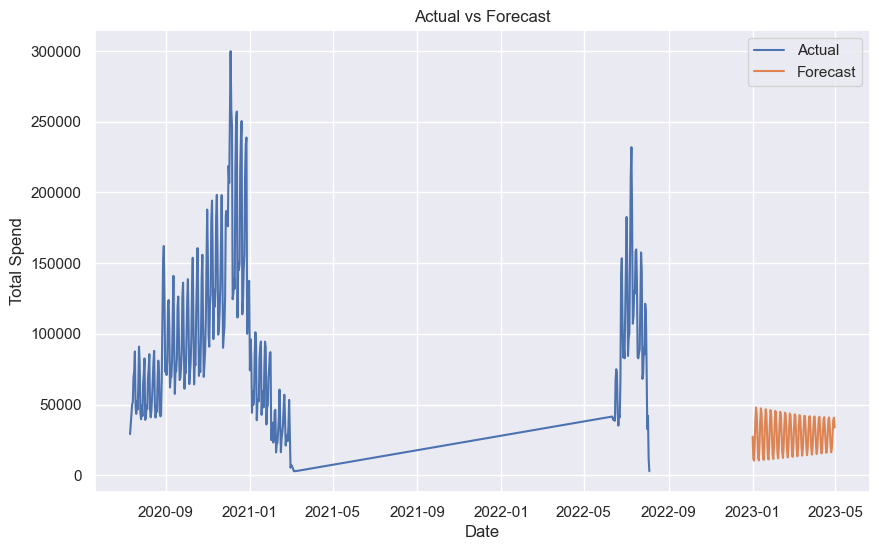

In [43]:
# Plot the actual data and the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Total Spend'], label='Actual')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast')
plt.xlabel('Date')
plt.ylabel('Total Spend')
plt.title('Actual vs Forecast')
plt.legend()
plt.show()

### Train test Split by date

In [ ]:
df['Date'] = df.index
# Take training data before 2022-01
train = df[df['Date'] < pd.to_datetime("2022-01-01", format='%Y-%m-%d')]
train['train'] = train["Total Spend"]
del train['Date']
del train["Total Spend"]

# Take testing data after 2022-01
test = df[df['Date'] >= pd.to_datetime("2022-01-01", format='%Y-%m-%d')]
del test['Date']
test['test'] = test["Total Spend"]
del test["Total Spend"]


### Hyperparameter tuning on ARIMA model (without using auto)

In [ ]:
# Hyperparameter Tuning
best_rmse = float('inf')
best_order = None

for p in range(3):
    for d in range(2):
        for q in range(3):
            order = (p, d, q)
            model = ARIMA(train_data['Total Spend'], order=order)
            model_fit = model.fit()

            # Forecast on the test set
            forecast = model_fit.forecast(steps=len(test_data))

            # Inverse transform the forecasted values
            forecast = np.exp(forecast)

            # Evaluate the forecast using root mean squared error (RMSE)
            rmse = np.sqrt(mean_squared_error(test_data['Total Spend'], forecast))

            # Update the best order if the RMSE is lower
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = order

# Fit the ARIMA model with the best order
model = ARIMA(df['Total Spend'], order=best_order)
model_fit = model.fit()

# Forecast for future dates
future_dates = pd.date_range(start='2022-12-26', end='2023-12-31', freq='D')
forecast = model_fit.forecast(steps=len(future_dates))

# Inverse transform the forecasted values
forecast = np.exp(forecast)

# Plot the forecasted values for future dates
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Total Spend'], label='Actual data')
plt.plot(future_dates, forecast, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Total Spend')
plt.title('Total Spend: Actual vs. Forecast')
plt.legend()
plt.show()

### ARIMA on "Sun Activity" data

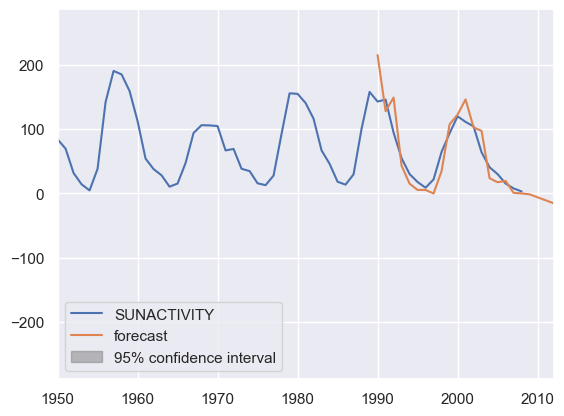

In [44]:
#source: https://www.statsmodels.org/v0.11.1/generated/statsmodels.tsa.arima_model.ARIMAResults.plot_predict.html
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

dta = sm.datasets.sunspots.load_pandas().data[['SUNACTIVITY']]
dta.index = pd.date_range(start='1700', end='2009', freq='A')
res = ARIMA(dta, order=(0,2,0)).fit()
fig, ax = plt.subplots()
ax = dta.loc['1950':].plot(ax=ax)
plot_predict(res, '1990', '2012', ax=ax)
plt.show()

### This proves that if the data has good pattern, ARIMA does work. For this task, it is a data challenge and not a model problem.